## Data Cleaning

In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import scipy as sp
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from collections import Counter
import ziptotimezone as z
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import graphviz 
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv('eBay_ML_Challenge_Dataset_2021_train.csv')

b2c_c2c = np.array(dataset["b2c_c2c"])
seller_id = np.array(dataset["seller_id"])
declared_handling_days = np.array(dataset["declared_handling_days"])
acceptance_scan_timestamp = np.array(dataset["acceptance_scan_timestamp"])
shipment_method_id = np.array(dataset["shipment_method_id"])
shipping_fee = np.array(dataset["shipping_fee"])
carrier_min_estimate = np.array(dataset["carrier_min_estimate"])
carrier_max_estimate = np.array(dataset["carrier_max_estimate"])
item_zip = dataset["item_zip"]
buyer_zip = dataset["buyer_zip"]
category_id = np.array(dataset["category_id"])
item_price = np.array(dataset["item_price"])
quantity = np.array(dataset["quantity"])
payment_datetime = np.array(dataset["payment_datetime"])
delivery_date = np.array(dataset["delivery_date"])
weight = np.array(dataset["weight"])
weight_units = np.array(dataset["weight_units"])
package_size = np.array(dataset["package_size"])

Encode b2c_c2c as numeric binary [0,1]

In [3]:
def b2c_c2c_to_binary(arr):
    if arr[0] in [0,1]:
        print("Array has already been converted to numeric binary!")
    else:
        for i in range(arr.shape[0]):
            if arr[i][0] == "B":
                arr[i] = 0
            else:
                arr[i] = 1
            
b2c_c2c_to_binary(b2c_c2c)
b2c_c2c = np.array(b2c_c2c, dtype=int)

Convert all times to the timezome of the buyer

Create labels for handling time (acceptance_scan_timestamp - payment_datetime), shipment time (delivery_date - acceptance_scan_timestamp), and total time (delivery_date - payment_datetime)

In [4]:
def round_datetime_to_date(datetime):
    days = datetime.days
    hours = datetime.seconds // 3600
    if hours > 12:
        return days + 1
    else:
        return days

def calculate_handling_and_delivery_days(acceptance_timestamps, payment_timestamps, delivery_date):
    handling_labels = []
    shipping_labels = []
    delivery_labels = []
    for i in range(acceptance_timestamps.shape[0]):
        raw_payment = payment_timestamps[i]
        raw_acceptance = acceptance_timestamps[i]
        #parse raw_payment time string to separate year, month, date, and time
        p_year, p_month, p_date = int(raw_payment[0:4]), int(raw_payment[5:7]), int(raw_payment[8:10])
        p_hour, p_min, p_sec = int(raw_payment[11:13]), int(raw_payment[14:16]), int(raw_payment[17:19])
        p_datetime = dt.datetime(year=p_year, month=p_month, day=p_date, hour=p_hour, minute=p_min, second=p_sec)
            
        #parse raw_acceptance time string to separate year, month, date, and time
        raw_acceptance = acceptance_timestamps[i]
        a_year, a_month, a_date = int(raw_acceptance[0:4]), int(raw_acceptance[5:7]), int(raw_acceptance[8:10])
        a_hour, a_min, a_sec = int(raw_acceptance[11:13]), int(raw_acceptance[14:16]), int(raw_acceptance[17:19])
        a_datetime = dt.datetime(year=a_year, month=a_month, day=a_date, hour=a_hour, minute=a_min, second=a_sec)
        
        raw_delivery = delivery_date[i]
        d_year, d_month, d_date = int(raw_delivery[0:4]), int(raw_delivery[5:7]), int(raw_delivery[8:10])
        d_date = dt.datetime(year=d_year, month=d_month, day=d_date, hour=17)
        
        #handling days = acceptance time - payment time; shipping days = delivery date - acceptance time
        handling_days = a_datetime - p_datetime
        shipping_days = d_date - a_datetime
        delivery_days = d_date - p_datetime
        
        #round to nearest day
        rounded_handling_days = round_datetime_to_date(handling_days)
        rounded_shipping_days = round_datetime_to_date(shipping_days)
        rounded_delivery_days = round_datetime_to_date(delivery_days)
        
        handling_labels.append(rounded_handling_days)
        shipping_labels.append(rounded_shipping_days)
        delivery_labels.append(rounded_delivery_days)
        
    return np.array(handling_labels), np.array(shipping_labels), np.array(delivery_labels)

In [5]:
handling_days, shipping_days, delivery_days = calculate_handling_and_delivery_days(acceptance_scan_timestamp, payment_datetime, delivery_date)

Quantify distance between buyer and seller using zipcode

In [6]:
import mpu
from uszipcode import SearchEngine
import pandas as pd


def get_distance(item_zip, buyer_zip):
    """
    Haversine formula using 'mpu' library which determines the
    great-circle distance between two points on a sphere.
    """
    if item_zip is not None and buyer_zip is not None:
        search = SearchEngine(simple_zipcode=True)

        zip1 = search.by_zipcode(item_zip[0:5])
        lat1 =zip1.lat
        long1 =zip1.lng
        print(str(lat1) + ", " + str(long1))

        zip2 =search.by_zipcode(buyer_zip[0:5])
        lat2 =zip2.lat
        long2 =zip2.lng
        print(str(lat2) + ", " + str(long2))

        if lat1 is None or lat2 is None or long1 is None or long2 is None:
            lat1, long1 = z.zip_to_central_lat_lon(int(item_zip))
            lat2, long2 = z.zip_to_central_lat_lon(int(buyer_zip))
        return mpu.haversine_distance((lat1,long1),(lat2,long2)) 
    else:
        return None


def add_zip_distance_column(item_zip, buyer_zip):
    item_zip_str = item_zip.apply(lambda x: str(x))
    buyer_zip_str = buyer_zip.apply(lambda x: str(x))

    zips = pd.concat([item_zip_str, buyer_zip_str], axis=1)

    zips['distance'] = zips.apply(lambda x: get_distance(x.item_zip, x.buyer_zip), axis=1)
    
    return zips['distance']

zips = add_zip_distance_column(item_zip, buyer_zip)

45.45, -122.7
41.97, -85.34
40.71, -73.83
39.8, -89.0
35.7, -80.2
43.6, -88.3
33.87, -118.07
39.9, -104.8
33.87, -118.07
45.4, -93.4
39.97, -83.03
29.74, -95.52
34.23, -118.63
41.72, -88.11
45.0, -84.6
34.7, -81.6
41.67, -83.6
27.8, -80.49
33.66, -86.88
37.64, -112.1
35.35, -119.06
38.89, -76.77
42.8, -96.2
35.5, -81.3
29.65, -95.48
40.0, -84.2
34.02, -117.85
35.8, -79.8
29.68, -82.39
25.82, -80.31
44.2, -70.6
38.0, -92.1
38.89, -76.9
37.33, -121.84
29.5, -95.9
44.83, -93.27
43.6, -116.4
29.3, -96.1
39.6, -74.6
39.9, -78.6
39.7, -121.8
39.9, -121.8
29.16, -81.03
43.3, -112.4
33.71, -117.31
41.49, -73.94
None, None
39.4, -104.5
None, None
37.9, -97.3
34.07, -118.01
31.8, -97.1
34.07, -118.01
27.1, -80.5
34.1, -118.42
34.15, -118.49
44.3, -88.6
32.78, -79.93
39.8, -76.0
42.9, -89.6
28.9, -82.6
33.4, -84.6
45.9, -89.5
45.6, -70.3
43.1, -78.96
36.7, -86.6
29.86, -95.34
28.73, -81.51
42.8, -96.2
40.1, -89.4
42.8, -96.2
40.2, -84.2
35.6, -82.6
33.2, -95.6
40.96, -74.12
34.06, -118.31
33.75, 

IndexError: string index out of range

Use weight_units to convert all weights to the same unit

In [7]:
def convert_weights():
    for i, unit in enumerate(weight_units):
        if unit == 2:
            #convert weight to lbs; 1 kg = 2.20462 lbs.
            weight[i] *= 2.20462
convert_weights()

Replace missing weight values with the average weight by category ID

In [8]:
def determine_weight_averages_by_category_id():
    category_id_weights = {}
    for i, w in enumerate(weight):
        category = category_id[i]
        if category not in category_id_weights:
            category_id_weights[category] = [w]
        else:
            category_id_weights[category].append(w)
    
    category_id_weight_means = {}
    for category in category_id_weights:
        weights = category_id_weights[category]
        average_weight = np.mean(weights)
        category_id_weight_means[category] = average_weight
    
    return category_id_weight_means

def fill_missing_weights():
    weight_means = determine_weight_averages_by_category_id()
    overall_mean = np.mean(weight)
    for i, w in enumerate(weight):
        if w == 0:
            #weight is missing, replace with average weight across same category id
            category = category_id[i]
            if category in weight_means:
                weight[i] = weight_means[category]
            else:
                #don't have records for this category id, so replace with overall average
                weight[i] = overall_mean
fill_missing_weights()

Encode package_size as discrete numeric values

In [9]:
def string_to_numeric_package_size():
    if type(package_size[0]) == int:
        print("Already converted to discrete numeric values")
    else:
        encodings = {"LETTER": 0, "PACKAGE_THICK_ENVELOPE": 1, "LARGE_ENVELOPE": 2,"VERY_LARGE_PACKAGE": 3, 
                     "LARGE_PACKAGE": 4, "EXTRA_LARGE_PACKAGE": 5, "NONE": -1}
        for i, size in enumerate(package_size):
            package_size[i] = encodings[size]
string_to_numeric_package_size()

Replace missing package_size values with the most likely size using weight

In [10]:
def determine_average_weight_by_package_size():
    package_size_weights = {}
    for i, w in enumerate(weight):
        p_size = package_size[i]
        if p_size not in package_size_weights:
            package_size_weights[p_size] = [w]
        else:
            package_size_weights[p_size].append(w)
    
    package_id_weight_means = {}
    for p_size in package_size_weights:
        weights = package_size_weights[p_size]
        average_weight = np.mean(weights)
        package_id_weight_means[p_size] = average_weight
    
    return package_id_weight_means

def fill_missing_package_sizes():
    weight_means = determine_average_weight_by_package_size()
    weight_means.pop(-1, None)
    weight_means_list = [weight_means[key] for key in weight_means]
    for i, s in enumerate(package_size):
        if s == -1:
            #package size is missing, replace with package size it's weight is closest to the average of
            w = weight[i]
            abs_function = lambda value: abs(value-w)
            closest_value = min(weight_means_list, key=abs_function)
            closest_p_size = weight_means_list.index(closest_value)
            package_size[i] = closest_p_size

fill_missing_package_sizes()

Replace missing carrier_min_estimate and carrier_max_estimate with averages from the same shipment_method_id. If there are no records for that shipment_method_id, replace with overall average across all shipment_method_id's.

In [11]:
def determine_average_shipping_estimates_by_shipment_method():    
    carrier_min_by_shipment_method = {}
    carrier_max_by_shipment_method = {}
    for i, method_id in enumerate(shipment_method_id):
        carrier_min = carrier_min_estimate[i]
        carrier_max = carrier_max_estimate[i]
        if method_id not in carrier_min_by_shipment_method:
            carrier_min_by_shipment_method[method_id] = [carrier_min]
        else:
            carrier_min_by_shipment_method[method_id].append(carrier_min)

        if method_id not in carrier_max_by_shipment_method:
            carrier_max_by_shipment_method[method_id] = [carrier_max]
        else:
            carrier_max_by_shipment_method[method_id].append(carrier_max)
    
    carrier_min_means = {}
    for method_id in carrier_min_by_shipment_method:
        min_estimates = carrier_min_by_shipment_method[method_id]
        mean_min_estimate = np.mean(min_estimates)
        carrier_min_means[method_id] = mean_min_estimate
    
    carrier_max_means = {}
    for method_id in carrier_max_by_shipment_method:
        max_estimates = carrier_max_by_shipment_method[method_id]
        mean_max_estimate = np.mean(max_estimates)
        carrier_max_means[method_id] = mean_max_estimate 
    
    return carrier_min_means, carrier_max_means

def fill_missing_carrier_estimates():
    carrier_min_means, carrier_max_means = determine_average_shipping_estimates_by_shipment_method()
    overall_min_mean, overall_max_mean = np.mean(carrier_min_estimate), np.mean(carrier_max_estimate)
    for i, estimate in enumerate(carrier_min_estimate):
        if estimate < 0:
            #need to fill value 
            method_id = shipment_method_id[i]
            if method_id in carrier_min_means:
                carrier_min_estimate[i] = carrier_min_means[method_id]
            else:
                carrier_min_estimate[i] = overall_min_mean
    for i, estimate in enumerate(carrier_max_estimate):
        if estimate < 0:
            #need to fill value
            method_id = shipment_method_id[i]
            if method_id in carrier_max_means:
                carrier_max_estimate[i] = carrier_max_means[method_id]
            else:
                carrier_max_estimate[i] = overall_max_mean

fill_missing_carrier_estimates()

Replace missing declared_handling_days with average from the same seller_id. If there are no records for that seller_id, replace with overall average across all sellers.

In [12]:
def fill_missing_declared_handling_days():
    overall_mean = np.mean(declared_handling_days)
    seller_counts = Counter(seller_id)
    for i, days in enumerate(declared_handling_days):
        if np.isnan(days):
            #need to fill
            declared_handling_days[i] = overall_mean
#COULD MAKE THIS BETTER BY DOING BY SELLER ID

In [13]:
features = np.column_stack((b2c_c2c, seller_id, declared_handling_days, shipment_method_id, shipping_fee,
                             carrier_min_estimate, carrier_max_estimate, category_id,
                             item_price, weight, package_size, handling_days))
labels = np.array(delivery_days)
handling_labels = np.array(handling_days)
shipping_labels = np.array(shipping_days)

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels)
handling_X_train, handling_X_test, handling_Y_train, handling_Y_test = train_test_split(features, handling_labels)
shipping_X_train, shipping_X_test, shipping_Y_train, shipping_Y_test = train_test_split(features, shipping_labels)

In [15]:
X_train = scale(X_train, with_mean=True, with_std=True)
X_test = scale(X_test, with_mean=True, with_std=True)
handling_X_train = scale(handling_X_train, with_mean=True, with_std=True)
handling_X_test = scale(handling_X_test, with_mean=True, with_std=True)
shipping_X_train = scale(shipping_X_train, with_mean=True, with_std=True)
shipping_X_test = scale(shipping_X_test, with_mean=True, with_std=True)

/opt/mambaforge/envs/cs152/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/mambaforge/envs/cs152/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/mambaforge/envs/cs152/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [16]:
xgbr = xgb.XGBRegressor(verbosity=0)
print(xgbr)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=0)


In [17]:
xgbr.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=40, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='approx', validate_parameters=1, verbosity=0)

In [18]:
train_score = xgbr.score(X_train, Y_train)
print(train_score)

0.6863894542225488


In [19]:
pred = xgbr.predict(X_test)
mse = mean_squared_error(Y_test, pred)
print(mse)

3.9188312931786387


In [20]:
def evaluate_loss(preds, actual):
    early_loss, late_loss = 0,0 
    for i in range(len(preds)):
        if preds[i] < actual[i]:
            #early shipment
            early_loss += actual[i] - preds[i]
        elif preds[i] > actual[i]:
            #late shipment
            late_loss += preds[i] - actual[i]
    loss = (1/len(preds)) * (0.4 * (early_loss) + 0.6 * (late_loss))
    return loss

In [21]:
print(evaluate_loss(pred, Y_test))

0.5300786547326438


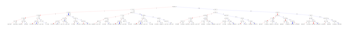

In [22]:
xgb.plot_tree(xgbr)
plt.savefig('tree.png', dpi=300)
plt.show()

In [23]:
print(xgbr.feature_importances_)

[0.00470502 0.01391438 0.0124221  0.01212137 0.00642627 0.0412479
 0.08207865 0.00904437 0.00842107 0.00675844 0.01387058 0.78898984]


In [31]:
print(xgbr.max_depth)

None


[0.00716152 0.0138678  0.0125318  0.01243079 0.00656817 0.04646778
 0.08607896 0.00716838 0.00732436 0.00689182 0.01321472 0.7802939 ]
 
b2c_c2c, seller_id, declared_handling_days, shipment_method_id, shipping_fee,
                             carrier_min_estimate, carrier_max_estimate, category_id,
                             item_price, weight, package_size, handling_days

importance < 0.01: b2c_c2c, shipping_fee, category_id, item_price, weight
0.01 < importance < 0.05: seller_id, declared_handling_days, shipment_method_id, carrier_min_estimate, package_size
0.05 < importance: carrier_max_estimate, handling_days

Try random forest with and without unimportant features
visualize correlation matrix as a heap map (can use seaborn)
Knock out experiments:
- knock out one feature and train 
- compare models (the one that has the largest hit from removing 1 feature tells that that feature is most important)
Try turning zip codes into floating point numbers and passing that into neural network

Let's use XGBoost to determine which features are important only for the handling period, and which are important only for the shipping period

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=0)
MSE:
22.76756258453385
Loss:
0.43506425964805373


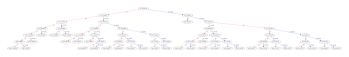

[2.66874991e-02 1.57523658e-02 1.91025324e-02 4.13970882e-03
 1.33468891e-02 2.09106889e-04 3.63922194e-02 1.04670925e-02
 1.02126561e-02 9.62290820e-03 4.79271309e-03 8.49274337e-01]


In [23]:
handling_xgbr = xgb.XGBRegressor(verbosity=0)
print(handling_xgbr)
handling_xgbr.fit(handling_X_train, handling_Y_train)
pred = handling_xgbr.predict(handling_X_test)
mse = mean_squared_error(handling_Y_test, pred)
print("MSE:")
print(mse)
print("Loss:")
print(evaluate_loss(pred, handling_Y_test))
xgb.plot_tree(handling_xgbr)
plt.savefig('handling_tree.png', dpi=300)
plt.show()
print(handling_xgbr.feature_importances_)

[2.66874991e-02 1.57523658e-02 1.91025324e-02 4.13970882e-03
 1.33468891e-02 2.09106889e-04 3.63922194e-02 1.04670925e-02
 1.02126561e-02 9.62290820e-03 4.79271309e-03 8.49274337e-01]
 
 b2c_c2c, seller_id, declared_handling_days, shipment_method_id, shipping_fee,
                             carrier_min_estimate, carrier_max_estimate, category_id,
                             item_price, weight, package_size, handling_days
                            
                             

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=0)
MSE:
18.531836014004373
Loss:
0.8092401947733605


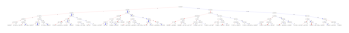

[0.03684181 0.05246348 0.07678234 0.03377131 0.02894857 0.26008287
 0.3404752  0.02395581 0.04662873 0.02663036 0.03651725 0.0369023 ]


In [24]:
shipping_xgbr = xgb.XGBRegressor(verbosity=0)
print(shipping_xgbr)
shipping_xgbr.fit(shipping_X_train, shipping_Y_train)
pred = shipping_xgbr.predict(shipping_X_test)
mse = mean_squared_error(shipping_Y_test, pred)
print("MSE:")
print(mse)
print("Loss:")
print(evaluate_loss(pred, shipping_Y_test))
xgb.plot_tree(shipping_xgbr)
plt.savefig('shipping_tree.png', dpi=300)
plt.show()
print(shipping_xgbr.feature_importances_)

[0.00974114 0.05542793 0.05909049 0.0481035  0.03052319 0.26555276
 0.3525968  0.01976914 0.04382701 0.03989847 0.03796855 0.03750111]
 
b2c_c2c, seller_id, declared_handling_days, shipment_method_id, shipping_fee, carrier_min_estimate, carrier_max_estimate, category_id, item_price, weight, package_size, handling_days

importance < 0.01: b2c_c2c

0.01 < importance < 0.05: shipment_method_id, shipping_fee, category_id, item_price, weight, package_size, handling days

importance > 0.05: seller_id, declared_handling_days, carrier_min_estimate, carrier_max_estimate
 

In [25]:
plt.savefig('shipping_tree.png', dpi=600)
plt.show()

<Figure size 432x288 with 0 Axes>

In [26]:
features.T.shape

(12, 15000000)

In [27]:
corr = np.corrcoef(np.array(features.T))

AttributeError: 'float' object has no attribute 'shape'